## Import packages

In [2]:
import rioxarray as rxr

In [35]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
# from osgeo import gdal
# from osgeo import gdalconst

import tempfile
import wget
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient


modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis_snow')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

## MODIS data

### Helper Functions

These helper functions are from a notebook example provided by [DrivenData](https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/) [here](https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/modis.ipynb). I also adopted the [code](https://github.com/M-Harrington/SnowComp) to load MODIS data from DrivenData user [@themrharrington](https://community.drivendata.org/u/themrharrington).

In [13]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

In [33]:
def images_downloader(tiles, centroids, out_dataset, prod_name, verbose = False):
    """"""
    cell_ids = []
    i = 0
    for date_tile in tiles.keys():
        print("\n",i)

        date = date_tile[0]
        daynum = daynum_gen(date)
        daynum_og = daynum #to save later
        tile_num = (date_tile[1],date_tile[2])

      
        folder = prod_name + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum

        # Find all HDF files from this tile on this day
        filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
        print('Found {} matching file(s):'.format(len(filenames)))
        for fn in filenames:
            print(fn)
        file_root = filenames.copy()
        
        if len(file_root) > 1: #images may come in multiples
            print("multiple files found: ", len(file_root))
            blob_name1 = filenames[0]
            blob_name2 = filenames[1]
            
            # Download to a temporary file
            url1 = modis_blob_root + blob_name1
            url2 = modis_blob_root + blob_name2

            filename = os.path.join(temp_dir,blob_name1.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url1,filename)
                
            filename = os.path.join(temp_dir,blob_name2.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url2,filename)
            rds1 = rxr.open_rasterio(filename)
            rds2 = rxr.open_rasterio(filename)
            
            #find highest quality image
            rds1_quality = ((rds1.NDSI_Snow_Cover_Basic_QA.values >0) | (rds1.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            rds2_quality = ((rds2.NDSI_Snow_Cover_Basic_QA.values >0) | (rds2.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            
            rds = rds1 if rds1_quality >= rds2_quality else rds2 
                
        else:
            # Work with the first returned URL
            file_found = False
            breaker = 1
            while not file_found and breaker <= 5:
                try:
                    blob_name = filenames[0]
                    file_found = True
                except IndexError:
                    print("No file found: tile {} date {}".format(tile_num,daynum))
                    date -= timedelta(days=1)
                    daynum = daynum_gen(date) 

                    breaker +=1 
                    print("trying:", daynum)
            if breaker == 5:
                raise ValueError("Image", tile_num, daynum, "not found")


            # Download to a temporary file
            url = modis_blob_root + blob_name
            filename = os.path.join(temp_dir,blob_name.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url,filename)

            rds = rxr.open_rasterio(filename)

        #####reproject#####
        image = rds.rio.reproject(dst_crs="EPSG:4326")
        for var in image.data_vars:
            image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 


        #####create blocks around centroids#####    
        cells = tiles[date_tile]
        for cell in cells:
            center = centroids[cell]


            x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
            y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

            #subset 21x21 square
            xmin, xmin_actual, xmax = max(x_idx -10, 0) , x_idx -10, x_idx + 11 
            ymin, ymin_actual, ymax = max(y_idx -10, 0) , y_idx -10, y_idx + 11

            sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

            try: # in case we're against boundary
                sub_image = sub_image.squeeze().to_array().to_numpy()
                out_dataset[i] = sub_image
            except ValueError as e:                
                #flip and reflip before saving because coding's hard
                sub_image = np.swapaxes(sub_image, 1,2)
                
                image_shape = tuple(image.dims[d] for d in ['x', 'y'])
                simage_shape = sub_image.shape
                if verbose:
                    print(e)
                    print("Out of bounds error, padding with 0 for day/grid:", daynum_og, cell)

                    print("input shape: ", image_shape, "output shape", simage_shape)
                    print("max/min", xmax, ymax, xmin, ymin)
                    
                #pad with necessary columns
                if xmin_actual < 0:                    
                    fill = np.zeros((out_dataset.shape[1],
                                     0-xmin_actual, simage_shape[1]))
                    sub_image = np.concatenate((fill, sub_image), axis= 1)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off left")
                        print("updated simage_shape", simage_shape)
                    
                elif xmax > image_shape[0]:
                    fill = np.zeros((out_dataset.shape[1],
                                    xmax- image_shape[0], simage_shape[1]))
                    sub_image = np.concatenate((sub_image, fill), axis=1)
                    simage_shape = sub_image.shape
                    print("off right")
                    print("updated simage_shape", simage_shape)
                
                if ymin_actual < 0 :
                    fill = np.zeros((out_dataset.shape[1],
                                   21, 0-ymin_actual ))
                    sub_image = np.concatenate((fill, sub_image), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off up")
                        print("updated simage_shape", simage_shape)

                elif ymax > image_shape[1]:
                    fill = np.zeros((out_dataset.shape[1],
                                     21, ymax - image_shape[1] ))
                    sub_image = np.concatenate((sub_image,fill), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off down")
                        print("updated simage_shape", simage_shape)
                    
                sub_image = np.swapaxes(sub_image, 1,2)
                out_dataset[i] = sub_image
                
                
                
            cell_ids.append((cell, daynum_og)) 

            i+=1
        
        
        
    return cell_ids, out_dataset


### Ground Measures Data

In [15]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md

station_id               name  elevation_m   latitude  \
0              CDEC:ADM      Adin Mountain  1889.760000  41.237000   
1              CDEC:AGP         Agnew Pass  2880.360000  37.726631   
2              CDEC:ALP       Alpha (Smud)  2316.480000  38.804192   
3              CDEC:BCB     Blackcap Basin  3139.440000  37.066685   
4              CDEC:BCH      Beach Meadows  2331.720000  36.126095   
..                  ...                ...          ...        ...   
759  SNOTEL:994_WA_SNTL  Epa Quinault Open    91.440002  46.483330   
760  SNOTEL:995_WA_SNTL   Epa Quinault Can    91.440002  46.483330   
761  SNOTEL:996_WA_SNTL   NWA Heather Mdws  1267.968018  48.849998   
762  SNOTEL:998_WA_SNTL          Easy Pass  1606.296021  48.859329   
763  SNOTEL:999_WA_SNTL       Marten Ridge  1072.895996  48.762920   

      longitude       state  
0   -120.792000  California  
1   -119.141731  California  
2   -120.215652  California  
3   -118.773010  California  
4   -118.293457  California  
..          ...         ...  
759 -123.966667  Washington  
760 -123.966667  Washington  
761 -121.666672  Washington  
762 -121.438950  Washington  
763 -121.698227  Washington  

[764 rows x 6 columns]

### Cell grids

This [dataset]("../data/grid_cells.geojson") provides us spatial information about the grid cells in the submission format.

In [16]:
path = "../data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [17]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [18]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [19]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['coordinates'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

cell_id  \
0      0003f387-71c4-48f6-b2b0-d853bd4f0aba   
1      000617d8-8c14-43e2-b708-7e3a69fe3cc3   
2      000863e7-21e6-477d-b799-f5675c348627   
3      000ba8d9-d6d5-48da-84a2-1fa54951fae1   
4      00146204-d4e9-4cd8-8f86-d1ef133c5b6d   
...                                     ...   
18125  ffdfb5a4-91a0-41a9-a4d5-501b04ef6326   
18126  ffe43514-2c92-43b6-bd84-d183806aca65   
18127  ffeabc13-7c6f-4b63-b043-19c8f15e0345   
18128  fff95195-ccc9-40b7-b302-a0d8570c86bc   
18129  fffb4d40-5947-4922-9f05-5d8b5a243d84   

                                             coordinates           region  
0      [[-118.718953, 37.074192], [-118.718953, 37.08...          sierras  
1      [[-107.076787, 37.780424], [-107.076787, 37.78...  central rockies  
2      [[-119.401673, 37.024005], [-119.401673, 37.03...            other  
3      [[-119.320824, 37.431707], [-119.320824, 37.43...          sierras  
4      [[-118.521324, 36.657353], [-118.521324, 36.66...          sierras  
...                                                  ...              ...  
18125  [[-118.620138, 37.117184], [-118.620138, 37.12...          sierras  
18126  [[-123.49799, 47.901318], [-123.49799, 47.9073...            other  
18127  [[-119.644218, 37.879756], [-119.644218, 37.88...          sierras  
18128  [[-123.372226, 47.732416], [-123.372226, 47.73...            other  
18129  [[-123.794435, 47.520516], [-123.794435, 47.52...            other  

[18130 rows x 3 columns]

Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [20]:
#test for one row
list(np.mean(grid_cell_df['coordinates'][1],axis=0))

[-107.0803802, 37.7832636]

In [21]:
#cellid : centroid
centroids = { x['cell_id']:list(np.mean(x['coordinates'],axis=0)) for index, x in grid_cell_df.iterrows()}
centroids

{'0003f387-71c4-48f6-b2b0-d853bd4f0aba': [-118.72254619999998,
  37.077058799999996],
 '000617d8-8c14-43e2-b708-7e3a69fe3cc3': [-107.0803802, 37.7832636],
 '000863e7-21e6-477d-b799-f5675c348627': [-119.4052662, 37.0268738],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': [-119.32441759999999, 37.4345602],
 '00146204-d4e9-4cd8-8f86-d1ef133c5b6d': [-118.5249172, 36.660235799999995],
 '0017d1c4-64cb-426d-9158-3f6521d2dd22': [-119.4322152, 37.2417204],
 '0020c632-3d5c-4509-b4ee-6b63a89bf2ff': [-118.90220920000002, 36.8545572],
 '00211c19-7ea8-4f21-a2de-1d6216186a96': [-106.9456332, 38.742496800000005],
 '0021411f-e7b5-48d7-9d36-abecbc255821': [-123.3129372, 47.9879678],
 '00226e82-e747-4f03-9c5d-3eef8ebe515e': [-120.0520532, 38.003026199999994],
 '0027a004-df14-4d66-a3e4-e987336b8814': [-106.80190259999999, 38.8824902],
 '002ccd85-65b3-4903-8725-4590d1f5611e': [-123.96870759999999, 47.6078018],
 '002cec08-f455-4e8c-8682-4d69861f4120': [-119.4232322, 37.8329446],
 '0036f966-3430-45f3-b6a2-803e678a

In [31]:
len(centroids)

18130

### Training data

#### Ground measures of Training data

Below is the ground measures from  for our training data from SNOTEL and CDEC sites.

In [22]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

station_id  2013-01-01  2013-01-08  2013-01-15  2013-01-22  \
0              CDEC:ADM        5.90        5.90        6.50        6.50   
1              CDEC:AGP       17.52       17.54       17.85       17.39   
2              CDEC:ALP       12.75       13.32       14.26       14.02   
3              CDEC:BCB        4.30        4.42        4.62        4.53   
4              CDEC:BCH        2.88        3.00        3.48        3.84   
..                  ...         ...         ...         ...         ...   
695  SNOTEL:989_ID_SNTL        9.00       10.20       10.90       11.10   
696  SNOTEL:990_WA_SNTL       27.50       29.10       31.50       31.90   
697  SNOTEL:992_UT_SNTL        4.10        4.10        4.40        4.50   
698  SNOTEL:998_WA_SNTL       48.40       55.50       61.50       62.20   
699  SNOTEL:999_WA_SNTL       33.10       37.50       40.80       42.50   

     2013-01-29  2013-02-05  2013-02-12  2013-02-19  2013-02-26  ...  \
0          7.40        7.60        7.40        8.00        8.00  ...   
1         18.03       17.70       17.65       16.66       17.21  ...   
2         13.39       13.25       14.30       13.95       15.73  ...   
3          4.67        4.90        4.90        5.06        5.11  ...   
4          3.96        4.44        5.40        5.16        3.60  ...   
..          ...         ...         ...         ...         ...  ...   
695       12.80       14.10       14.40       14.60       17.60  ...   
696       33.40       33.90       35.40       36.50       38.80  ...   
697        4.80        5.10        5.20        5.30        6.10  ...   
698       67.50       70.10       72.90       77.00       83.30  ...   
699       47.50       51.00       53.90       56.40       64.50  ...   

     2019-05-28  2019-06-04  2019-06-11  2019-06-18  2019-06-25  2019-12-03  \
0           NaN         NaN         NaN         NaN         NaN        0.70   
1           NaN         NaN         NaN         NaN         NaN        0.00   
2         29.52       20.81        8.71        0.30        0.00        5.69   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4          0.84        0.60        0.36        0.36        0.24        2.88   
..          ...         ...         ...         ...         ...         ...   
695        0.00        0.00        0.00        0.00        0.00        0.30   
696        6.00        0.10        0.00        0.00        0.00        1.00   
697        0.00        0.00        0.00        0.00        0.00        2.00   
698       53.60       36.10       31.30        8.50        0.00        8.00   
699        1.30        0.00        0.00        0.00        0.00        1.60   

     2019-12-10  2019-12-17  2019-12-24  2019-12-31  
0          1.20        3.40        3.70        3.40  
1          0.60        0.20         NaN         NaN  
2          8.04       10.74       12.67       12.57  
3           NaN         NaN         NaN         NaN  
4          4.56        4.68        5.04        6.00  
..          ...         ...         ...         ...  
695        0.20        1.60        2.80        3.00  
696        0.90        2.30        8.70        8.60  
697        2.20        3.50        3.60        3.80  
698        9.00       13.20       23.70       25.00  
699        0.20        3.50        8.40        9.40  

[700 rows x 214 columns]

#### Train Labels

In [23]:
y_train = pd.read_csv("../data/train_labels.csv")
y_train

cell_id  2013-01-01  2013-01-08  \
0      0003f387-71c4-48f6-b2b0-d853bd4f0aba         NaN         NaN   
1      000617d8-8c14-43e2-b708-7e3a69fe3cc3         NaN         NaN   
2      000ba8d9-d6d5-48da-84a2-1fa54951fae1         NaN         NaN   
3      0017d1c4-64cb-426d-9158-3f6521d2dd22         NaN         NaN   
4      0020c632-3d5c-4509-b4ee-6b63a89bf2ff         NaN         NaN   
...                                     ...         ...         ...   
10873  ffdc53d2-5565-496a-b849-4fcf33f33a36         NaN         NaN   
10874  ffdfb5a4-91a0-41a9-a4d5-501b04ef6326         NaN         NaN   
10875  ffe43514-2c92-43b6-bd84-d183806aca65         NaN         NaN   
10876  fff95195-ccc9-40b7-b302-a0d8570c86bc         NaN         NaN   
10877  fffb4d40-5947-4922-9f05-5d8b5a243d84         NaN         NaN   

       2013-01-15  2013-01-22  2013-01-29  2013-02-05  2013-02-12  2013-02-19  \
0             NaN         NaN         NaN         NaN         NaN         NaN   
1             NaN         NaN         NaN         NaN         NaN         NaN   
2             NaN         NaN         NaN         NaN         NaN         NaN   
3             NaN         NaN         NaN         NaN         NaN         NaN   
4             NaN         NaN         NaN         NaN         NaN         NaN   
...           ...         ...         ...         ...         ...         ...   
10873         NaN         NaN         NaN         NaN         NaN         NaN   
10874         NaN         NaN         NaN         NaN         NaN         NaN   
10875         NaN         NaN         NaN         NaN         NaN         NaN   
10876         NaN         NaN         NaN         NaN         NaN         NaN   
10877         NaN         NaN         NaN         NaN         NaN         NaN   

       2013-02-26  ...  2019-06-13  2019-06-14  2019-06-18  2019-06-24  \
0             NaN  ...         NaN         NaN         NaN         NaN   
1             NaN  ...         NaN         NaN         NaN         NaN   
2             NaN  ...         NaN         0.0         NaN         NaN   
3             NaN  ...         NaN         NaN         NaN         NaN   
4             NaN  ...         NaN         NaN         NaN         NaN   
...           ...  ...         ...         ...         ...         ...   
10873         NaN  ...         NaN         NaN         NaN         NaN   
10874         NaN  ...         NaN         NaN         NaN         NaN   
10875         NaN  ...         NaN         NaN         NaN         NaN   
10876         NaN  ...         NaN         NaN         NaN         NaN   
10877         NaN  ...         NaN         NaN         NaN         NaN   

       2019-06-25  2019-12-03  2019-12-10  2019-12-17  2019-12-24  2019-12-31  
0             NaN         NaN         NaN         NaN         NaN         NaN  
1             NaN         NaN         NaN         NaN         NaN         NaN  
2             NaN         NaN         NaN         NaN         NaN         NaN  
3             NaN         NaN         NaN         NaN         NaN         NaN  
4             NaN         NaN         NaN         NaN         NaN         NaN  
...           ...         ...         ...         ...         ...         ...  
10873         NaN         NaN         NaN         NaN         NaN         NaN  
10874         NaN         NaN         NaN         NaN         NaN         NaN  
10875         NaN         NaN         NaN         NaN         NaN         NaN  
10876         NaN         NaN         NaN         NaN         NaN         NaN  
10877         NaN         NaN         NaN         NaN         NaN         NaN  

[10878 rows x 268 columns]

In [24]:
y_train_melt = y_train.melt(id_vars=["cell_id"]).dropna()
y_train_melt.rename(columns={"variable":'date'},inplace=True)
y_train_grouped = y_train_melt.groupby('cell_id')

#grab date/cell_id combos
#cell_id : [dates]
dates = {key:(list(group['date'])) for key, group in y_train_grouped}
dates

{'0003f387-71c4-48f6-b2b0-d853bd4f0aba': ['2018-04-26',
  '2019-03-16',
  '2019-04-18',
  '2019-04-28',
  '2019-06-08'],
 '000617d8-8c14-43e2-b708-7e3a69fe3cc3': ['2016-04-03'],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': ['2018-03-04',
  '2018-04-22',
  '2018-06-01',
  '2019-03-15',
  '2019-03-25',
  '2019-05-01',
  '2019-06-14'],
 '0017d1c4-64cb-426d-9158-3f6521d2dd22': ['2018-04-23',
  '2018-06-02',
  '2019-03-15',
  '2019-06-05'],
 '0020c632-3d5c-4509-b4ee-6b63a89bf2ff': ['2018-04-26',
  '2019-03-16',
  '2019-03-26',
  '2019-04-18',
  '2019-04-28'],
 '0021411f-e7b5-48d7-9d36-abecbc255821': ['2016-02-08', '2016-03-29'],
 '0027a004-df14-4d66-a3e4-e987336b8814': ['2018-03-31',
  '2018-05-24',
  '2019-04-07',
  '2019-06-10'],
 '002ccd85-65b3-4903-8725-4590d1f5611e': ['2016-02-08', '2016-03-29'],
 '002cec08-f455-4e8c-8682-4d69861f4120': ['2018-04-25',
  '2019-03-29',
  '2019-06-04'],
 '0036f966-3430-45f3-b6a2-803e678a1c2b': ['2019-04-07', '2019-06-10'],
 '003bc010-4187-4fba-9c3c-29ca50b15a

In [25]:
len(y_train_melt)

91490

Even after dropping nulls, we still have 91490 training labels to work use as ground truth. Now let's compile overlapping tiles.

In [28]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in dates.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

total squares: 91490


In [29]:
tiles

defaultdict(list,
            {(datetime.datetime(2018, 4, 26, 0, 0),
              8,
              5): ['0003f387-71c4-48f6-b2b0-d853bd4f0aba', '0020c632-3d5c-4509-b4ee-6b63a89bf2ff', '00559e5b-310a-4514-8123-2a3074828d74', '00748c91-2e34-44ea-ab63-51c10bf77497', '0095cd70-ad71-485a-a670-64fc5604db98', '00b78996-1639-40d2-a943-2126ec4ef2e1', '00c0b91c-9aa7-4d9b-a44f-abb91acd49d2', '0158d4f1-037e-421a-aeed-58db7a086512', '01724a51-925e-4d33-879f-837f436383b4', '01867838-b8c1-45b2-bf01-a262d18c95ec', '01909e72-97ba-4c53-85d6-15d4410a6b57', '01a0f55a-2c5e-4539-8c74-7d315031b51f', '01a191f1-2d34-4886-a72f-53e3c24f7356', '01b0d56b-f1d2-436d-a0ae-bc605eede64a', '01ccdf49-83ed-470f-8d82-3c89973bbb8c', '01ee5268-f209-420e-a888-59ac08261065', '01f9c9c0-d9a6-416b-96fe-2c43d250517b', '020d17b2-4720-4c0b-b876-20aa707bf4c2', '0266d61d-71e0-4ebc-895d-a42a872a90b9', '0267b104-ed40-490f-9028-bc93b0799eb6', '02e48cc0-3e23-4d26-a4ab-6bc3563a4dc2', '0375fb6a-15b1-4512-81c4-10af44681aa9', '040ee994-56f7

#### Load Modis Terra Training images (morning)

In [36]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids, dataset_t, product)
    
#####save output#####
output_path = "../sat_images/ModisSnowImagesT.npy"
np.save(output_path,dataset_t)

path_ids = "../sat_images/cell_snow_idsT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)


 0
Found 1 matching file(s):
MOD10A1/08/05/2018116/MOD10A1.A2018116.h08v05.006.2018118031402.hdf

 1468
Found 1 matching file(s):
MOD10A1/08/05/2019075/MOD10A1.A2019075.h08v05.006.2019077031831.hdf

 2937
Found 1 matching file(s):
MOD10A1/08/05/2019108/MOD10A1.A2019108.h08v05.006.2019110033147.hdf

 4406
Found 1 matching file(s):
MOD10A1/08/05/2019118/MOD10A1.A2019118.h08v05.006.2019120033847.hdf

 5875
Found 1 matching file(s):
MOD10A1/08/05/2019159/MOD10A1.A2019159.h08v05.006.2019161025247.hdf

 6740
Found 1 matching file(s):
MOD10A1/09/05/2016094/MOD10A1.A2016094.h09v05.006.2016104070530.hdf

 7910
Found 1 matching file(s):
MOD10A1/08/05/2018063/MOD10A1.A2018063.h08v05.006.2018065091856.hdf

 8503
Found 1 matching file(s):
MOD10A1/08/05/2018112/MOD10A1.A2018112.h08v05.006.2018114031316.hdf

 9110
Found 1 matching file(s):
MOD10A1/08/05/2018152/MOD10A1.A2018152.h08v05.006.2018154033710.hdf

 10111
Found 1 matching file(s):
MOD10A1/08/05/2019074/MOD10A1.A2019074.h08v05.006.2019076031


 33437
Found 1 matching file(s):
MOD10A1/08/04/2014119/MOD10A1.A2014119.h08v04.006.2016170141445.hdf

 33443
Found 1 matching file(s):
MOD10A1/08/04/2014126/MOD10A1.A2014126.h08v04.006.2016170144515.hdf

 33449
Found 1 matching file(s):
MOD10A1/08/04/2014133/MOD10A1.A2014133.h08v04.006.2016170160349.hdf

 33455
Found 1 matching file(s):
MOD10A1/08/04/2014140/MOD10A1.A2014140.h08v04.006.2016170044759.hdf

 33461
Found 1 matching file(s):
MOD10A1/08/04/2014147/MOD10A1.A2014147.h08v04.006.2016170050145.hdf

 33467
Found 1 matching file(s):
MOD10A1/08/04/2014154/MOD10A1.A2014154.h08v04.006.2016170033117.hdf

 33473
Found 1 matching file(s):
MOD10A1/08/04/2014161/MOD10A1.A2014161.h08v04.006.2016170071247.hdf

 33479
Found 1 matching file(s):
MOD10A1/08/04/2014168/MOD10A1.A2014168.h08v04.006.2016170213654.hdf

 33485
Found 1 matching file(s):
MOD10A1/08/04/2014175/MOD10A1.A2014175.h08v04.006.2016170192519.hdf

 33491
Found 1 matching file(s):
MOD10A1/08/04/2014336/MOD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MOD10A1/08/04/2017094/MOD10A1.A2017094.h08v04.006.2017096053335.hdf

 33949
Found 1 matching file(s):
MOD10A1/08/04/2017101/MOD10A1.A2017101.h08v04.006.2017103033744.hdf

 33956
Found 1 matching file(s):
MOD10A1/08/04/2017108/MOD10A1.A2017108.h08v04.006.2017110030801.hdf

 33963
Found 1 matching file(s):
MOD10A1/08/04/2017115/MOD10A1.A2017115.h08v04.006.2017117025933.hdf

 33970
Found 1 matching file(s):
MOD10A1/08/04/2017122/MOD10A1.A2017122.h08v04.006.2017124031701.hdf

 33977
Found 1 matching file(s):
MOD10A1/08/04/2017129/MOD10A1.A2017129.h08v04.006.2017137214927.hdf

 33983
Found 1 matching file(s):
MOD10A1/08/04/2017136/MOD10A1.A2017136.h08v04.006.2017138030804.hdf

 33989
Found 1 matching file(s):
MOD10A1/08/04/2017143/MOD10A1.A2017143.h08v04.006.2017145031639.hdf

 33994
Found 1 matching file(s):
MOD10A1/08/04/2017150/MOD10A1.A2017150.h08v04.006.2017152031055.hdf

 33999
Found 1 matching file(s):
MOD10A1/08/04/2017157/MOD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MOD10A1/08/05/2016117/MOD10A1.A2016117.h08v05.006.2016119065405.hdf

 37292
Found 1 matching file(s):
MOD10A1/08/05/2016130/MOD10A1.A2016130.h08v05.006.2016132074011.hdf

 38019
Found 1 matching file(s):
MOD10A1/08/05/2017029/MOD10A1.A2017029.h08v05.006.2017032012323.hdf

 38726
Found 1 matching file(s):
MOD10A1/08/05/2018148/MOD10A1.A2018148.h08v05.006.2018150042246.hdf

 39433
Found 1 matching file(s):
MOD10A1/08/05/2019107/MOD10A1.A2019107.h08v05.006.2019109032744.hdf

 40424
Found 1 matching file(s):
MOD10A1/08/05/2019123/MOD10A1.A2019123.h08v05.006.2019125234149.hdf

 41133
Found 1 matching file(s):
MOD10A1/08/05/2019164/MOD10A1.A2019164.h08v05.006.2019166033705.hdf

 41842
Found 1 matching file(s):
MOD10A1/09/05/2018089/MOD10A1.A2018089.h09v05.006.2018093185834.hdf

 42223
Found 1 matching file(s):
MOD10A1/09/05/2019098/MOD10A1.A2019098.h09v05.006.2019100033234.hdf

 42522
Found 1 matching file(s):
MOD10A1/09/05/2019160/MOD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MOD10A1/08/05/2015020/MOD10A1.A2015020.h08v05.006.2016173060803.hdf

 48795
Found 1 matching file(s):
MOD10A1/08/05/2015027/MOD10A1.A2015027.h08v05.006.2016173060920.hdf

 48826
Found 1 matching file(s):
MOD10A1/08/05/2015034/MOD10A1.A2015034.h08v05.006.2016173061014.hdf

 48857
Found 1 matching file(s):
MOD10A1/08/05/2015041/MOD10A1.A2015041.h08v05.006.2016173061131.hdf

 48888
Found 1 matching file(s):
MOD10A1/08/05/2015048/MOD10A1.A2015048.h08v05.006.2016173234839.hdf

 48919
Found 1 matching file(s):
MOD10A1/08/05/2015055/MOD10A1.A2015055.h08v05.006.2016174011608.hdf

 48950
Found 1 matching file(s):
MOD10A1/08/05/2015062/MOD10A1.A2015062.h08v05.006.2016173234221.hdf

 48980
Found 1 matching file(s):
MOD10A1/08/05/2015069/MOD10A1.A2015069.h08v05.006.2016173140448.hdf

 49011
Found 1 matching file(s):
MOD10A1/08/05/2015076/MOD10A1.A2015076.h08v05.006.2016173140325.hdf

 49042
Found 1 matching file(s):
MOD10A1/08/05/2015083/MOD10A1.A2015083.h08v05.00


 51107
Found 1 matching file(s):
MOD10A1/08/05/2017150/MOD10A1.A2017150.h08v05.006.2017152032856.hdf

 51135
Found 1 matching file(s):
MOD10A1/08/05/2017157/MOD10A1.A2017157.h08v05.006.2017159034556.hdf

 51163
Found 1 matching file(s):
MOD10A1/08/05/2017164/MOD10A1.A2017164.h08v05.006.2017166030123.hdf

 51191
Found 1 matching file(s):
MOD10A1/08/05/2017171/MOD10A1.A2017171.h08v05.006.2017173030919.hdf

 51218
Found 1 matching file(s):
MOD10A1/08/05/2017339/MOD10A1.A2017339.h08v05.006.2017341031007.hdf

 51247
Found 1 matching file(s):
MOD10A1/08/05/2017346/MOD10A1.A2017346.h08v05.006.2017348031129.hdf

 51276
Found 1 matching file(s):
MOD10A1/08/05/2017353/MOD10A1.A2017353.h08v05.006.2017355030231.hdf

 51305
Found 1 matching file(s):
MOD10A1/08/05/2017360/MOD10A1.A2017360.h08v05.006.2017362032454.hdf

 51334
Found 1 matching file(s):
MOD10A1/08/05/2018002/MOD10A1.A2018002.h08v05.006.2018004030713.hdf

 51363
Found 1 matching file(s):
MOD10A1/08/05/2018009/MOD10A1.A2018009.h08v05.00


 54025
Found 1 matching file(s):
MOD10A1/10/04/2013085/MOD10A1.A2013085.h10v04.006.2016139195613.hdf

 54074
Found 1 matching file(s):
MOD10A1/10/04/2013092/MOD10A1.A2013092.h10v04.006.2016139044617.hdf

 54123
Found 1 matching file(s):
MOD10A1/10/04/2013099/MOD10A1.A2013099.h10v04.006.2016139213038.hdf

 54172
Found 1 matching file(s):
MOD10A1/10/04/2013106/MOD10A1.A2013106.h10v04.006.2016139005006.hdf

 54221
Found 1 matching file(s):
MOD10A1/10/04/2013113/MOD10A1.A2013113.h10v04.006.2016139010155.hdf

 54270
Found 1 matching file(s):
MOD10A1/10/04/2013120/MOD10A1.A2013120.h10v04.006.2016140060719.hdf

 54319
Found 1 matching file(s):
MOD10A1/10/04/2013127/MOD10A1.A2013127.h10v04.006.2016140060751.hdf

 54368
Found 1 matching file(s):
MOD10A1/10/04/2013134/MOD10A1.A2013134.h10v04.006.2016142050711.hdf

 54417
Found 1 matching file(s):
MOD10A1/10/04/2013141/MOD10A1.A2013141.h10v04.006.2016142055456.hdf

 54466
Found 1 matching file(s):
MOD10A1/10/04/2013148/MOD10A1.A2013148.h10v04.00


 57994
Found 1 matching file(s):
MOD10A1/10/04/2016012/MOD10A1.A2016012.h10v04.006.2016182220242.hdf

 58043
Found 1 matching file(s):
MOD10A1/10/04/2016019/MOD10A1.A2016019.h10v04.006.2016021065536.hdf

 58092
Found 1 matching file(s):
MOD10A1/10/04/2016026/MOD10A1.A2016026.h10v04.006.2016028091537.hdf

 58141
Found 1 matching file(s):
MOD10A1/10/04/2016033/MOD10A1.A2016033.h10v04.006.2016036011953.hdf

 58190
Found 1 matching file(s):
MOD10A1/10/04/2016040/MOD10A1.A2016040.h10v04.006.2016042071912.hdf

 58239
Found 1 matching file(s):
MOD10A1/10/04/2016047/MOD10A1.A2016047.h10v04.006.2016049071539.hdf

 58288
Found 0 matching file(s):
No file found: tile (10, 4) date 2016054
trying: 2016053
No file found: tile (10, 4) date 2016053
trying: 2016052
No file found: tile (10, 4) date 2016052
trying: 2016051
No file found: tile (10, 4) date 2016051
trying: 2016050
No file found: tile (10, 4) date 2016050
trying: 2016049

 58337
Found 1 matching file(s):
MOD10A1/10/04/2016061/MOD10A1.A2016


 61840
Found 1 matching file(s):
MOD10A1/10/04/2018142/MOD10A1.A2018142.h10v04.006.2018144033522.hdf

 61888
Found 1 matching file(s):
MOD10A1/10/04/2018149/MOD10A1.A2018149.h10v04.006.2018151040520.hdf

 61936
Found 1 matching file(s):
MOD10A1/10/04/2018156/MOD10A1.A2018156.h10v04.006.2018158035030.hdf

 61984
Found 1 matching file(s):
MOD10A1/10/04/2018163/MOD10A1.A2018163.h10v04.006.2018166205104.hdf

 62032
Found 1 matching file(s):
MOD10A1/10/04/2018170/MOD10A1.A2018170.h10v04.006.2018172032026.hdf

 62080
Found 1 matching file(s):
MOD10A1/10/04/2018177/MOD10A1.A2018177.h10v04.006.2018179032850.hdf

 62128
Found 1 matching file(s):
MOD10A1/10/04/2018338/MOD10A1.A2018338.h10v04.006.2018340034328.hdf

 62177
Found 1 matching file(s):
MOD10A1/10/04/2018345/MOD10A1.A2018345.h10v04.006.2018347025910.hdf

 62226
Found 1 matching file(s):
MOD10A1/10/04/2018352/MOD10A1.A2018352.h10v04.006.2018354025820.hdf

 62275
Found 1 matching file(s):
MOD10A1/10/04/2018359/MOD10A1.A2018359.h10v04.00


 67363
Found 1 matching file(s):
MOD10A1/09/04/2014070/MOD10A1.A2014070.h09v04.006.2016169075628.hdf

 67451
Found 1 matching file(s):
MOD10A1/09/04/2014077/MOD10A1.A2014077.h09v04.006.2016169073520.hdf

 67539
Found 1 matching file(s):
MOD10A1/09/04/2014084/MOD10A1.A2014084.h09v04.006.2016169045231.hdf

 67627
Found 1 matching file(s):
MOD10A1/09/04/2014091/MOD10A1.A2014091.h09v04.006.2016169054347.hdf

 67715
Found 1 matching file(s):
MOD10A1/09/04/2014098/MOD10A1.A2014098.h09v04.006.2016169215509.hdf

 67803
Found 1 matching file(s):
MOD10A1/09/04/2014105/MOD10A1.A2014105.h09v04.006.2016169234831.hdf

 67891
Found 1 matching file(s):
MOD10A1/09/04/2014112/MOD10A1.A2014112.h09v04.006.2016170140311.hdf

 67979
Found 1 matching file(s):
MOD10A1/09/04/2014119/MOD10A1.A2014119.h09v04.006.2016170141427.hdf

 68067
Found 1 matching file(s):
MOD10A1/09/04/2014126/MOD10A1.A2014126.h09v04.006.2016170152507.hdf

 68155
Found 1 matching file(s):
MOD10A1/09/04/2014133/MOD10A1.A2014133.h09v04.00


 74284
Found 1 matching file(s):
MOD10A1/09/04/2016355/MOD10A1.A2016355.h09v04.006.2016357132030.hdf

 74369
Found 1 matching file(s):
MOD10A1/09/04/2016362/MOD10A1.A2016362.h09v04.006.2016364101237.hdf

 74455
Found 1 matching file(s):
MOD10A1/09/04/2017003/MOD10A1.A2017003.h09v04.006.2017006135045.hdf

 74541
Found 1 matching file(s):
MOD10A1/09/04/2017010/MOD10A1.A2017010.h09v04.006.2017012100743.hdf

 74627
Found 1 matching file(s):
MOD10A1/09/04/2017017/MOD10A1.A2017017.h09v04.006.2017020201509.hdf

 74713
Found 1 matching file(s):
MOD10A1/09/04/2017024/MOD10A1.A2017024.h09v04.006.2017026120827.hdf

 74799
Found 1 matching file(s):
MOD10A1/09/04/2017031/MOD10A1.A2017031.h09v04.006.2017033101506.hdf

 74884
Found 1 matching file(s):
MOD10A1/09/04/2017038/MOD10A1.A2017038.h09v04.006.2017040202337.hdf

 74971
Found 1 matching file(s):
MOD10A1/09/04/2017045/MOD10A1.A2017045.h09v04.006.2017047103812.hdf

 75058
Found 1 matching file(s):
MOD10A1/09/04/2017052/MOD10A1.A2017052.h09v04.00


 81312
Found 1 matching file(s):
MOD10A1/09/04/2019134/MOD10A1.A2019134.h09v04.006.2019136025805.hdf

 81399
Found 1 matching file(s):
MOD10A1/09/04/2019141/MOD10A1.A2019141.h09v04.006.2019143034341.hdf

 81486
Found 1 matching file(s):
MOD10A1/09/04/2019148/MOD10A1.A2019148.h09v04.006.2019150032905.hdf

 81573
Found 1 matching file(s):
MOD10A1/09/04/2019155/MOD10A1.A2019155.h09v04.006.2019157034453.hdf

 81660
Found 1 matching file(s):
MOD10A1/09/04/2019162/MOD10A1.A2019162.h09v04.006.2019165193133.hdf

 81747
Found 1 matching file(s):
MOD10A1/09/04/2019169/MOD10A1.A2019169.h09v04.006.2019171034534.hdf

 81834
Found 1 matching file(s):
MOD10A1/09/04/2019176/MOD10A1.A2019176.h09v04.006.2019178030033.hdf

 81921
Found 1 matching file(s):
MOD10A1/09/04/2019337/MOD10A1.A2019337.h09v04.006.2019339032546.hdf

 82008
Found 1 matching file(s):
MOD10A1/09/04/2019344/MOD10A1.A2019344.h09v04.006.2019346033051.hdf

 82095
Found 1 matching file(s):
MOD10A1/09/04/2019351/MOD10A1.A2019351.h09v04.00


 85254
Found 1 matching file(s):
MOD10A1/09/05/2015062/MOD10A1.A2015062.h09v05.006.2016173234242.hdf

 85296
Found 1 matching file(s):
MOD10A1/09/05/2015069/MOD10A1.A2015069.h09v05.006.2016173140234.hdf

 85338
Found 1 matching file(s):
MOD10A1/09/05/2015076/MOD10A1.A2015076.h09v05.006.2016173140320.hdf

 85380
Found 1 matching file(s):
MOD10A1/09/05/2015083/MOD10A1.A2015083.h09v05.006.2016174161632.hdf

 85422
Found 1 matching file(s):
MOD10A1/09/05/2015090/MOD10A1.A2015090.h09v05.006.2016174164901.hdf

 85464
Found 1 matching file(s):
MOD10A1/09/05/2015097/MOD10A1.A2015097.h09v05.006.2016174172314.hdf

 85506
Found 1 matching file(s):
MOD10A1/09/05/2015104/MOD10A1.A2015104.h09v05.006.2016175070326.hdf

 85548
Found 1 matching file(s):
MOD10A1/09/05/2015111/MOD10A1.A2015111.h09v05.006.2016175080925.hdf

 85590
Found 1 matching file(s):
MOD10A1/09/05/2015118/MOD10A1.A2015118.h09v05.006.2016175093439.hdf

 85632
Found 1 matching file(s):
MOD10A1/09/05/2015125/MOD10A1.A2015125.h09v05.00


 88600
Found 1 matching file(s):
MOD10A1/09/05/2017339/MOD10A1.A2017339.h09v05.006.2017341031124.hdf

 88643
Found 1 matching file(s):
MOD10A1/09/05/2017346/MOD10A1.A2017346.h09v05.006.2017348031200.hdf

 88685
Found 1 matching file(s):
MOD10A1/09/05/2017353/MOD10A1.A2017353.h09v05.006.2017355030233.hdf

 88728
Found 1 matching file(s):
MOD10A1/09/05/2017360/MOD10A1.A2017360.h09v05.006.2017362032414.hdf

 88771
Found 1 matching file(s):
MOD10A1/09/05/2018002/MOD10A1.A2018002.h09v05.006.2018004031124.hdf

 88814
Found 1 matching file(s):
MOD10A1/09/05/2018009/MOD10A1.A2018009.h09v05.006.2018011030829.hdf

 88857
Found 1 matching file(s):
MOD10A1/09/05/2018016/MOD10A1.A2018016.h09v05.006.2018018032245.hdf

 88900
Found 1 matching file(s):
MOD10A1/09/05/2018023/MOD10A1.A2018023.h09v05.006.2018025030038.hdf

 88943
Found 1 matching file(s):
MOD10A1/09/05/2018030/MOD10A1.A2018030.h09v05.006.2018032030845.hdf

 88986
Found 1 matching file(s):
MOD10A1/09/05/2018037/MOD10A1.A2018037.h09v05.00

FileNotFoundError: [Errno 2] No such file or directory: './sat_images/ModisSnowImagesT.npy'

In [37]:
#####save output#####
output_path = "../sat_images/ModisSnowImagesT.npy"
np.save(output_path,dataset_t)

path_ids = "../sat_images/cell_snow_idsT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

In [73]:
len(cell_ids)

91490

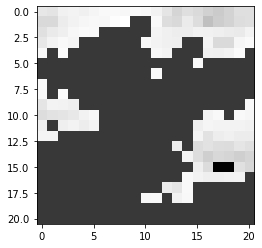

In [70]:
plt.imshow(dataset_t[1000,4,:,:],cmap='Greys')

In [61]:
dataset_t[1000,4,:,:].mean()


93.70521541950113

In [71]:
dataset_t[1000,4,0,:]

array([36., 38., 28., 26., 29., 23., 19., 18., 21., 17., 20., 27., 37.,
       49., 42., 45., 51., 55., 50., 42., 42.])

#### Load MODIS Aqua training images (afternoon)

In [38]:
product = 'MYD10A1' # Aqua -afternoon

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids, dataset_a = images_downloader(tiles, centroids, dataset_a, product)
    
#####save output#####
output_path = "../sat_images/ModisSnowImagesA.npy"
np.save(output_path,dataset_a)

path_ids = "../sat_images/cell_snow_idsA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)


 0
Found 1 matching file(s):
MYD10A1/08/05/2018116/MYD10A1.A2018116.h08v05.006.2018118031436.hdf

 1468
Found 1 matching file(s):
MYD10A1/08/05/2019075/MYD10A1.A2019075.h08v05.006.2019079193507.hdf

 2937
Found 1 matching file(s):
MYD10A1/08/05/2019108/MYD10A1.A2019108.h08v05.006.2019110032220.hdf

 4406
Found 1 matching file(s):
MYD10A1/08/05/2019118/MYD10A1.A2019118.h08v05.006.2019120031417.hdf

 5875
Found 1 matching file(s):
MYD10A1/08/05/2019159/MYD10A1.A2019159.h08v05.006.2019161033901.hdf

 6740
Found 1 matching file(s):
MYD10A1/09/05/2016094/MYD10A1.A2016094.h09v05.006.2016096071259.hdf

 7910
Found 1 matching file(s):
MYD10A1/08/05/2018063/MYD10A1.A2018063.h08v05.006.2018065092827.hdf

 8503
Found 1 matching file(s):
MYD10A1/08/05/2018112/MYD10A1.A2018112.h08v05.006.2018114031106.hdf

 9110
Found 1 matching file(s):
MYD10A1/08/05/2018152/MYD10A1.A2018152.h08v05.006.2018154033800.hdf

 10111
Found 1 matching file(s):
MYD10A1/08/05/2019074/MYD10A1.A2019074.h08v05.006.2019076025


 33437
Found 1 matching file(s):
MYD10A1/08/04/2014119/MYD10A1.A2014119.h08v04.006.2016170160735.hdf

 33443
Found 1 matching file(s):
MYD10A1/08/04/2014126/MYD10A1.A2014126.h08v04.006.2016170151749.hdf

 33449
Found 1 matching file(s):
MYD10A1/08/04/2014133/MYD10A1.A2014133.h08v04.006.2016170180700.hdf

 33455
Found 1 matching file(s):
MYD10A1/08/04/2014140/MYD10A1.A2014140.h08v04.006.2016170055939.hdf

 33461
Found 1 matching file(s):
MYD10A1/08/04/2014147/MYD10A1.A2014147.h08v04.006.2016170041237.hdf

 33467
Found 1 matching file(s):
MYD10A1/08/04/2014154/MYD10A1.A2014154.h08v04.006.2016170044949.hdf

 33473
Found 1 matching file(s):
MYD10A1/08/04/2014161/MYD10A1.A2014161.h08v04.006.2016170082502.hdf

 33479
Found 1 matching file(s):
MYD10A1/08/04/2014168/MYD10A1.A2014168.h08v04.006.2016170220105.hdf

 33485
Found 1 matching file(s):
MYD10A1/08/04/2014175/MYD10A1.A2014175.h08v04.006.2016170195411.hdf

 33491
Found 1 matching file(s):
MYD10A1/08/04/2014336/MYD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MYD10A1/08/04/2017094/MYD10A1.A2017094.h08v04.006.2017096062319.hdf

 33949
Found 1 matching file(s):
MYD10A1/08/04/2017101/MYD10A1.A2017101.h08v04.006.2017103033907.hdf

 33956
Found 1 matching file(s):
MYD10A1/08/04/2017108/MYD10A1.A2017108.h08v04.006.2017110042804.hdf

 33963
Found 1 matching file(s):
MYD10A1/08/04/2017115/MYD10A1.A2017115.h08v04.006.2017117150038.hdf

 33970
Found 1 matching file(s):
MYD10A1/08/04/2017122/MYD10A1.A2017122.h08v04.006.2017124031523.hdf

 33977
Found 1 matching file(s):
MYD10A1/08/04/2017129/MYD10A1.A2017129.h08v04.006.2017131204254.hdf

 33983
Found 1 matching file(s):
MYD10A1/08/04/2017136/MYD10A1.A2017136.h08v04.006.2017138033623.hdf

 33989
Found 1 matching file(s):
MYD10A1/08/04/2017143/MYD10A1.A2017143.h08v04.006.2017145031438.hdf

 33994
Found 1 matching file(s):
MYD10A1/08/04/2017150/MYD10A1.A2017150.h08v04.006.2017152030429.hdf

 33999
Found 1 matching file(s):
MYD10A1/08/04/2017157/MYD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MYD10A1/08/05/2016117/MYD10A1.A2016117.h08v05.006.2016119065226.hdf

 37292
Found 1 matching file(s):
MYD10A1/08/05/2016130/MYD10A1.A2016130.h08v05.006.2016132063510.hdf

 38019
Found 1 matching file(s):
MYD10A1/08/05/2017029/MYD10A1.A2017029.h08v05.006.2017032095146.hdf

 38726
Found 1 matching file(s):
MYD10A1/08/05/2018148/MYD10A1.A2018148.h08v05.006.2018150042714.hdf

 39433
Found 1 matching file(s):
MYD10A1/08/05/2019107/MYD10A1.A2019107.h08v05.006.2019109032945.hdf

 40424
Found 1 matching file(s):
MYD10A1/08/05/2019123/MYD10A1.A2019123.h08v05.006.2019125233813.hdf

 41133
Found 1 matching file(s):
MYD10A1/08/05/2019164/MYD10A1.A2019164.h08v05.006.2019166033029.hdf

 41842
Found 1 matching file(s):
MYD10A1/09/05/2018089/MYD10A1.A2018089.h09v05.006.2018091031556.hdf

 42223
Found 1 matching file(s):
MYD10A1/09/05/2019098/MYD10A1.A2019098.h09v05.006.2019100033454.hdf

 42522
Found 1 matching file(s):
MYD10A1/09/05/2019160/MYD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MYD10A1/08/05/2015020/MYD10A1.A2015020.h08v05.006.2016173073416.hdf

 48795
Found 1 matching file(s):
MYD10A1/08/05/2015027/MYD10A1.A2015027.h08v05.006.2016173060925.hdf

 48826
Found 1 matching file(s):
MYD10A1/08/05/2015034/MYD10A1.A2015034.h08v05.006.2016173061026.hdf

 48857
Found 1 matching file(s):
MYD10A1/08/05/2015041/MYD10A1.A2015041.h08v05.006.2016173081025.hdf

 48888
Found 1 matching file(s):
MYD10A1/08/05/2015048/MYD10A1.A2015048.h08v05.006.2016174010746.hdf

 48919
Found 1 matching file(s):
MYD10A1/08/05/2015055/MYD10A1.A2015055.h08v05.006.2016174013904.hdf

 48950
Found 1 matching file(s):
MYD10A1/08/05/2015062/MYD10A1.A2015062.h08v05.006.2016174014658.hdf

 48980
Found 1 matching file(s):
MYD10A1/08/05/2015069/MYD10A1.A2015069.h08v05.006.2016173155335.hdf

 49011
Found 1 matching file(s):
MYD10A1/08/05/2015076/MYD10A1.A2015076.h08v05.006.2016173155421.hdf

 49042
Found 1 matching file(s):
MYD10A1/08/05/2015083/MYD10A1.A2015083.h08v05.00


 51163
Found 1 matching file(s):
MYD10A1/08/05/2017164/MYD10A1.A2017164.h08v05.006.2017166032218.hdf

 51191
Found 1 matching file(s):
MYD10A1/08/05/2017171/MYD10A1.A2017171.h08v05.006.2017173032330.hdf

 51218
Found 1 matching file(s):
MYD10A1/08/05/2017339/MYD10A1.A2017339.h08v05.006.2017341031150.hdf

 51247
Found 1 matching file(s):
MYD10A1/08/05/2017346/MYD10A1.A2017346.h08v05.006.2017348030936.hdf

 51276
Found 1 matching file(s):
MYD10A1/08/05/2017353/MYD10A1.A2017353.h08v05.006.2017355232832.hdf

 51305
Found 1 matching file(s):
MYD10A1/08/05/2017360/MYD10A1.A2017360.h08v05.006.2017362032317.hdf

 51334
Found 1 matching file(s):
MYD10A1/08/05/2018002/MYD10A1.A2018002.h08v05.006.2018004030619.hdf

 51363
Found 1 matching file(s):
MYD10A1/08/05/2018009/MYD10A1.A2018009.h08v05.006.2018011030723.hdf

 51392
Found 1 matching file(s):
MYD10A1/08/05/2018016/MYD10A1.A2018016.h08v05.006.2018018032325.hdf

 51421
Found 1 matching file(s):
MYD10A1/08/05/2018023/MYD10A1.A2018023.h08v05.00


 54123
Found 1 matching file(s):
MYD10A1/10/04/2013099/MYD10A1.A2013099.h10v04.006.2016139044638.hdf

 54172
Found 1 matching file(s):
MYD10A1/10/04/2013106/MYD10A1.A2013106.h10v04.006.2016139025213.hdf

 54221
Found 1 matching file(s):
MYD10A1/10/04/2013113/MYD10A1.A2013113.h10v04.006.2016139010210.hdf

 54270
Found 1 matching file(s):
MYD10A1/10/04/2013120/MYD10A1.A2013120.h10v04.006.2016139220529.hdf

 54319
Found 1 matching file(s):
MYD10A1/10/04/2013127/MYD10A1.A2013127.h10v04.006.2016140020332.hdf

 54368
Found 1 matching file(s):
MYD10A1/10/04/2013134/MYD10A1.A2013134.h10v04.006.2016142052906.hdf

 54417
Found 1 matching file(s):
MYD10A1/10/04/2013141/MYD10A1.A2013141.h10v04.006.2016142055332.hdf

 54466
Found 1 matching file(s):
MYD10A1/10/04/2013148/MYD10A1.A2013148.h10v04.006.2016142021131.hdf

 54515
Found 1 matching file(s):
MYD10A1/10/04/2013155/MYD10A1.A2013155.h10v04.006.2016143222049.hdf

 54564
Found 1 matching file(s):
MYD10A1/10/04/2013162/MYD10A1.A2013162.h10v04.00


 58092
Found 1 matching file(s):
MYD10A1/10/04/2016026/MYD10A1.A2016026.h10v04.006.2016028074338.hdf

 58141
Found 1 matching file(s):
MYD10A1/10/04/2016033/MYD10A1.A2016033.h10v04.006.2016035134713.hdf

 58190
Found 1 matching file(s):
MYD10A1/10/04/2016040/MYD10A1.A2016040.h10v04.006.2016042065140.hdf

 58239
Found 1 matching file(s):
MYD10A1/10/04/2016047/MYD10A1.A2016047.h10v04.006.2016049063537.hdf

 58288
Found 1 matching file(s):
MYD10A1/10/04/2016054/MYD10A1.A2016054.h10v04.006.2016056075708.hdf

 58337
Found 1 matching file(s):
MYD10A1/10/04/2016061/MYD10A1.A2016061.h10v04.006.2016065015920.hdf

 58386
Found 1 matching file(s):
MYD10A1/10/04/2016068/MYD10A1.A2016068.h10v04.006.2016070071805.hdf

 58435
Found 1 matching file(s):
MYD10A1/10/04/2016075/MYD10A1.A2016075.h10v04.006.2016077104231.hdf

 58484
Found 1 matching file(s):
MYD10A1/10/04/2016082/MYD10A1.A2016082.h10v04.006.2016084143524.hdf

 58533
Found 1 matching file(s):
MYD10A1/10/04/2016089/MYD10A1.A2016089.h10v04.00


 62032
Found 1 matching file(s):
MYD10A1/10/04/2018170/MYD10A1.A2018170.h10v04.006.2018172031644.hdf

 62080
Found 1 matching file(s):
MYD10A1/10/04/2018177/MYD10A1.A2018177.h10v04.006.2018179032725.hdf

 62128
Found 1 matching file(s):
MYD10A1/10/04/2018338/MYD10A1.A2018338.h10v04.006.2018340034413.hdf

 62177
Found 1 matching file(s):
MYD10A1/10/04/2018345/MYD10A1.A2018345.h10v04.006.2018347031303.hdf

 62226
Found 1 matching file(s):
MYD10A1/10/04/2018352/MYD10A1.A2018352.h10v04.006.2018355201200.hdf

 62275
Found 1 matching file(s):
MYD10A1/10/04/2018359/MYD10A1.A2018359.h10v04.006.2018361032725.hdf

 62324
Found 1 matching file(s):
MYD10A1/10/04/2019001/MYD10A1.A2019001.h10v04.006.2019003031614.hdf

 62373
Found 1 matching file(s):
MYD10A1/10/04/2019008/MYD10A1.A2019008.h10v04.006.2019010201633.hdf

 62422
Found 1 matching file(s):
MYD10A1/10/04/2019015/MYD10A1.A2019015.h10v04.006.2019017025336.hdf

 62471
Found 1 matching file(s):
MYD10A1/10/04/2019022/MYD10A1.A2019022.h10v04.00


 67715
Found 1 matching file(s):
MYD10A1/09/04/2014098/MYD10A1.A2014098.h09v04.006.2016169223610.hdf

 67803
Found 1 matching file(s):
MYD10A1/09/04/2014105/MYD10A1.A2014105.h09v04.006.2016170005117.hdf

 67891
Found 1 matching file(s):
MYD10A1/09/04/2014112/MYD10A1.A2014112.h09v04.006.2016170154538.hdf

 67979
Found 1 matching file(s):
MYD10A1/09/04/2014119/MYD10A1.A2014119.h09v04.006.2016170160808.hdf

 68067
Found 1 matching file(s):
MYD10A1/09/04/2014126/MYD10A1.A2014126.h09v04.006.2016170151822.hdf

 68155
Found 1 matching file(s):
MYD10A1/09/04/2014133/MYD10A1.A2014133.h09v04.006.2016170180658.hdf

 68243
Found 1 matching file(s):
MYD10A1/09/04/2014140/MYD10A1.A2014140.h09v04.006.2016170055938.hdf

 68331
Found 1 matching file(s):
MYD10A1/09/04/2014147/MYD10A1.A2014147.h09v04.006.2016170041439.hdf

 68419
Found 1 matching file(s):
MYD10A1/09/04/2014154/MYD10A1.A2014154.h09v04.006.2016170045032.hdf

 68507
Found 1 matching file(s):
MYD10A1/09/04/2014161/MYD10A1.A2014161.h09v04.00


 74799
Found 1 matching file(s):
MYD10A1/09/04/2017031/MYD10A1.A2017031.h09v04.006.2017040040739.hdf

 74884
Found 1 matching file(s):
MYD10A1/09/04/2017038/MYD10A1.A2017038.h09v04.006.2017040123613.hdf

 74971
Found 1 matching file(s):
MYD10A1/09/04/2017045/MYD10A1.A2017045.h09v04.006.2017047060812.hdf

 75058
Found 1 matching file(s):
MYD10A1/09/04/2017052/MYD10A1.A2017052.h09v04.006.2017054101509.hdf

 75145
Found 1 matching file(s):
MYD10A1/09/04/2017059/MYD10A1.A2017059.h09v04.006.2017061203400.hdf

 75232
Found 1 matching file(s):
MYD10A1/09/04/2017066/MYD10A1.A2017066.h09v04.006.2017070020224.hdf

 75319
Found 1 matching file(s):
MYD10A1/09/04/2017073/MYD10A1.A2017073.h09v04.006.2017075075644.hdf

 75406
Found 1 matching file(s):
MYD10A1/09/04/2017080/MYD10A1.A2017080.h09v04.006.2017082120207.hdf

 75493
Found 1 matching file(s):
MYD10A1/09/04/2017087/MYD10A1.A2017087.h09v04.006.2017089111044.hdf

 75580
Found 1 matching file(s):
MYD10A1/09/04/2017094/MYD10A1.A2017094.h09v04.00


 81834
Found 1 matching file(s):
MYD10A1/09/04/2019176/MYD10A1.A2019176.h09v04.006.2019178032522.hdf

 81921
Found 1 matching file(s):
MYD10A1/09/04/2019337/MYD10A1.A2019337.h09v04.006.2019339034307.hdf

 82008
Found 1 matching file(s):
MYD10A1/09/04/2019344/MYD10A1.A2019344.h09v04.006.2019346035119.hdf

 82095
Found 1 matching file(s):
MYD10A1/09/04/2019351/MYD10A1.A2019351.h09v04.006.2019353033952.hdf

 82182
Found 1 matching file(s):
MYD10A1/09/04/2019358/MYD10A1.A2019358.h09v04.006.2019360181200.hdf

 82269
Found 1 matching file(s):
MYD10A1/09/04/2019365/MYD10A1.A2019365.h09v04.006.2020002223820.hdf

 82356
Found 1 matching file(s):
MYD10A1/09/05/2013001/MYD10A1.A2013001.h09v05.006.2016134181015.hdf

 82398
Found 1 matching file(s):
MYD10A1/09/05/2013008/MYD10A1.A2013008.h09v05.006.2016134232626.hdf

 82440
Found 1 matching file(s):
MYD10A1/09/05/2013015/MYD10A1.A2013015.h09v05.006.2016134214925.hdf

 82482
Found 1 matching file(s):
MYD10A1/09/05/2013022/MYD10A1.A2013022.h09v05.00


 85506
Found 1 matching file(s):
MYD10A1/09/05/2015104/MYD10A1.A2015104.h09v05.006.2016175104748.hdf

 85548
Found 1 matching file(s):
MYD10A1/09/05/2015111/MYD10A1.A2015111.h09v05.006.2016175113351.hdf

 85590
Found 1 matching file(s):
MYD10A1/09/05/2015118/MYD10A1.A2015118.h09v05.006.2016175114702.hdf

 85632
Found 1 matching file(s):
MYD10A1/09/05/2015125/MYD10A1.A2015125.h09v05.006.2016175102934.hdf

 85674
Found 1 matching file(s):
MYD10A1/09/05/2015132/MYD10A1.A2015132.h09v05.006.2016175013952.hdf

 85716
Found 1 matching file(s):
MYD10A1/09/05/2015139/MYD10A1.A2015139.h09v05.006.2016174232429.hdf

 85758
Found 1 matching file(s):
MYD10A1/09/05/2015146/MYD10A1.A2015146.h09v05.006.2016174234200.hdf

 85800
Found 1 matching file(s):
MYD10A1/09/05/2015153/MYD10A1.A2015153.h09v05.006.2016175002656.hdf

 85842
Found 1 matching file(s):
MYD10A1/09/05/2015160/MYD10A1.A2015160.h09v05.006.2016175194749.hdf

 85884
Found 1 matching file(s):
MYD10A1/09/05/2015167/MYD10A1.A2015167.h09v05.00


 88943
Found 1 matching file(s):
MYD10A1/09/05/2018030/MYD10A1.A2018030.h09v05.006.2018032030808.hdf

 88986
Found 1 matching file(s):
MYD10A1/09/05/2018037/MYD10A1.A2018037.h09v05.006.2018039031537.hdf

 89029
Found 1 matching file(s):
MYD10A1/09/05/2018044/MYD10A1.A2018044.h09v05.006.2018046030051.hdf

 89072
Found 1 matching file(s):
MYD10A1/09/05/2018051/MYD10A1.A2018051.h09v05.006.2018053031800.hdf

 89115
Found 1 matching file(s):
MYD10A1/09/05/2018058/MYD10A1.A2018058.h09v05.006.2018060034538.hdf

 89158
Found 1 matching file(s):
MYD10A1/09/05/2018065/MYD10A1.A2018065.h09v05.006.2018067025414.hdf

 89201
Found 1 matching file(s):
MYD10A1/09/05/2018072/MYD10A1.A2018072.h09v05.006.2018074032651.hdf

 89244
Found 1 matching file(s):
MYD10A1/09/05/2018079/MYD10A1.A2018079.h09v05.006.2018081134630.hdf

 89287
Found 1 matching file(s):
MYD10A1/09/05/2018086/MYD10A1.A2018086.h09v05.006.2018088203614.hdf

 89330
Found 1 matching file(s):
MYD10A1/09/05/2018093/MYD10A1.A2018093.h09v05.00

### Testing Data

#### Ground measures of testing data

The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

In [39]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

station_id  2020-01-07  2020-01-14  2020-01-21  2020-01-28  \
0              CDEC:ADM        4.50        5.50        7.30        8.30   
1              CDEC:AGP         NaN         NaN         NaN         NaN   
2              CDEC:ALP       12.72       13.78       17.12       18.07   
3              CDEC:BCB       12.20       12.20       13.30       13.35   
4              CDEC:BCH        6.60        5.76        5.16        7.68   
..                  ...         ...         ...         ...         ...   
695  SNOTEL:989_ID_SNTL        6.80       12.50       13.10       14.40   
696  SNOTEL:990_WA_SNTL       13.80       17.00       20.30       24.90   
697  SNOTEL:992_UT_SNTL        4.40        5.00        5.80        6.20   
698  SNOTEL:998_WA_SNTL       37.90       47.00       51.80       61.90   
699  SNOTEL:999_WA_SNTL       17.70       23.60       27.90       32.00   

     2020-02-04  2020-02-11  2020-02-18  2020-02-25  2020-03-03  ...  \
0          8.10        8.20        9.30        8.50        7.90  ...   
1           NaN         NaN         NaN         NaN         NaN  ...   
2         18.17       18.38       17.71       16.05       14.62  ...   
3         12.85       12.72       12.72       12.80       13.16  ...   
4          4.68        1.32        0.84        0.84        0.24  ...   
..          ...         ...         ...         ...         ...  ...   
695       16.30       19.10       19.80       19.80       19.70  ...   
696       26.70       29.40       29.80       31.10       32.60  ...   
697        6.30        6.80        7.20        7.40        7.80  ...   
698       69.00       73.40       77.30       81.40       83.60  ...   
699       33.70       39.90       44.20       48.10       52.60  ...   

     2021-04-27  2021-05-04  2021-05-11  2021-05-18  2021-05-25  2021-06-01  \
0          0.30         NaN         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2          3.34        0.31        0.02        0.00        0.13        0.01   
3         15.44       11.94        5.91        1.10        0.86        1.04   
4          0.12        0.24        0.24        0.24        0.12        0.24   
..          ...         ...         ...         ...         ...         ...   
695        6.10        0.00        0.00        0.00        0.00        0.00   
696       41.20       38.10       35.90       32.10       28.50       23.20   
697        0.00        0.00        0.00        0.00        0.00        0.00   
698       96.00       95.10       95.50       94.20       94.20         NaN   
699       68.10       64.30       64.00       57.50       52.60       44.80   

     2021-06-08  2021-06-15  2021-06-22  2021-06-29  
0           NaN         NaN         NaN         NaN  
1           NaN         NaN         NaN         NaN  
2          0.00        0.00        0.00        0.00  
3          1.12        1.04        1.17        1.25  
4          0.12        0.24        0.24        0.36  
..          ...         ...         ...         ...  
695        0.00        0.00        0.00        0.00  
696       16.70       10.60        0.90        0.00  
697        0.00        0.00        0.00        0.00  
698       75.10       70.40       58.70       35.10  
699       33.30       26.30       13.60        0.00  

[700 rows x 58 columns]

#### Testing labels

In [40]:
y_test = pd.read_csv("../data/submission_format.csv")
y_test

cell_id  2020-01-07  2020-01-14  \
0     000863e7-21e6-477d-b799-f5675c348627         0.0         0.0   
1     000ba8d9-d6d5-48da-84a2-1fa54951fae1         0.0         0.0   
2     00146204-d4e9-4cd8-8f86-d1ef133c5b6d         0.0         0.0   
3     00211c19-7ea8-4f21-a2de-1d6216186a96         0.0         0.0   
4     00226e82-e747-4f03-9c5d-3eef8ebe515e         0.0         0.0   
...                                    ...         ...         ...   
9061  ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99         0.0         0.0   
9062  ffce8731-d78f-4c06-ace2-7029b611f1ba         0.0         0.0   
9063  ffd1aa25-27a5-4b28-abb6-e6577d1575be         0.0         0.0   
9064  ffdfb5a4-91a0-41a9-a4d5-501b04ef6326         0.0         0.0   
9065  ffeabc13-7c6f-4b63-b043-19c8f15e0345         0.0         0.0   

      2020-01-21  2020-01-28  2020-02-04  2020-02-11  2020-02-18  2020-02-25  \
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            0.0         0.0         0.0         0.0         0.0         0.0   
2            0.0         0.0         0.0         0.0         0.0         0.0   
3            0.0         0.0         0.0         0.0         0.0         0.0   
4            0.0         0.0         0.0         0.0         0.0         0.0   
...          ...         ...         ...         ...         ...         ...   
9061         0.0         0.0         0.0         0.0         0.0         0.0   
9062         0.0         0.0         0.0         0.0         0.0         0.0   
9063         0.0         0.0         0.0         0.0         0.0         0.0   
9064         0.0         0.0         0.0         0.0         0.0         0.0   
9065         0.0         0.0         0.0         0.0         0.0         0.0   

      2020-03-03  ...  2021-04-27  2021-05-04  2021-05-11  2021-05-18  \
0            0.0  ...         0.0         0.0         0.0         0.0   
1            0.0  ...         0.0         0.0         0.0         0.0   
2            0.0  ...         0.0         0.0         0.0         0.0   
3            0.0  ...         0.0         0.0         0.0         0.0   
4            0.0  ...         0.0         0.0         0.0         0.0   
...          ...  ...         ...         ...         ...         ...   
9061         0.0  ...         0.0         0.0         0.0         0.0   
9062         0.0  ...         0.0         0.0         0.0         0.0   
9063         0.0  ...         0.0         0.0         0.0         0.0   
9064         0.0  ...         0.0         0.0         0.0         0.0   
9065         0.0  ...         0.0         0.0         0.0         0.0   

      2021-05-25  2021-06-01  2021-06-08  2021-06-15  2021-06-22  2021-06-29  
0            0.0         0.0         0.0         0.0         0.0         0.0  
1            0.0         0.0         0.0         0.0         0.0         0.0  
2            0.0         0.0         0.0         0.0         0.0         0.0  
3            0.0         0.0         0.0         0.0         0.0         0.0  
4            0.0         0.0         0.0         0.0         0.0         0.0  
...          ...         ...         ...         ...         ...         ...  
9061         0.0         0.0         0.0         0.0         0.0         0.0  
9062         0.0         0.0         0.0         0.0         0.0         0.0  
9063         0.0         0.0         0.0         0.0         0.0         0.0  
9064         0.0         0.0         0.0         0.0         0.0         0.0  
9065         0.0         0.0         0.0         0.0         0.0         0.0  

[9066 rows x 58 columns]

In [46]:
y_test_melt = y_test.melt(id_vars=["cell_id"]).dropna()
y_test_melt.rename(columns={"variable":'date'},inplace=True)
y_test_grouped = y_test_melt.groupby('cell_id')

#grab date/cell_id combos
#cell_id : [dates]
dates_sub = {key:(list(group['date'])) for key, group in y_test_grouped}
dates_sub

{'000863e7-21e6-477d-b799-f5675c348627': ['2020-01-07',
  '2020-01-14',
  '2020-01-21',
  '2020-01-28',
  '2020-02-04',
  '2020-02-11',
  '2020-02-18',
  '2020-02-25',
  '2020-03-03',
  '2020-03-10',
  '2020-03-17',
  '2020-03-24',
  '2020-03-31',
  '2020-04-07',
  '2020-04-14',
  '2020-04-21',
  '2020-04-28',
  '2020-05-05',
  '2020-05-12',
  '2020-05-19',
  '2020-05-26',
  '2020-06-02',
  '2020-06-09',
  '2020-06-16',
  '2020-06-23',
  '2020-06-30',
  '2020-12-01',
  '2020-12-08',
  '2020-12-15',
  '2020-12-22',
  '2020-12-29',
  '2021-01-05',
  '2021-01-12',
  '2021-01-19',
  '2021-01-26',
  '2021-02-02',
  '2021-02-09',
  '2021-02-16',
  '2021-02-23',
  '2021-03-02',
  '2021-03-09',
  '2021-03-16',
  '2021-03-23',
  '2021-03-30',
  '2021-04-06',
  '2021-04-13',
  '2021-04-20',
  '2021-04-27',
  '2021-05-04',
  '2021-05-11',
  '2021-05-18',
  '2021-05-25',
  '2021-06-01',
  '2021-06-08',
  '2021-06-15',
  '2021-06-22',
  '2021-06-29'],
 '000ba8d9-d6d5-48da-84a2-1fa54951fae1': ['2020

In [48]:
# create dictionary tiles_sub (date, lat, lon) : [cell_ids]
counter_sub = 0 
tiles_sub = defaultdict(list)
for cell, date_list in dates_sub.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_sub[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter_sub += 1
print("total squares:", counter_sub)   

total squares: 516762


#### Load MODIS Terra Test images (Morning)

In [50]:
product = 'MOD10A1'

#initialize empty array
dataset_sub_t = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_t = images_downloader(tiles_sub, centroids, dataset_sub_t, product)
    
#####save output#####
output_path = "../sat_images/ModisSnowImages_testT.npy"
np.save(output_path,dataset_sub_t)

path_ids = "../sat_images/cell_snow_ids_testT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

MemoryError: Unable to allocate 11.9 GiB for an array with shape (516762, 7, 21, 21) and data type float64

#### Load MODIS Aqua Test images (Afternoon)

In [51]:
product = 'MYD10A1'

#initialize empty array
dataset_sub_a = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_a = images_downloader(tiles_sub, centroids, dataset_sub_a, product)
    
#####save output#####
output_path = "../sat_images/ModisSnowImages_testA.npy"
np.save(output_path,dataset_sub_a)

path_ids = "../sat_images/cell_snow_ids_testA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

MemoryError: Unable to allocate 11.9 GiB for an array with shape (516762, 7, 21, 21) and data type float64